# Install required libraries


In [ ]:
!pip install -q kaggle albumentations opencv-python-headless matplotlib

#Upload kaggle.json for API access

Note: you will need a kaggle.json file that can be downloaded from kaggle.

In [2]:
from google.colab import files
files.upload()  # Upload your kaggle.json here

# Step 2: Configure Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 3: Download and unzip the Kaggle dataset
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset
!unzip -q tuberculosis-tb-chest-xray-dataset.zip -d ./chest_xray

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 99% 660M/663M [00:04<00:00, 173MB/s]
100% 663M/663M [00:04<00:00, 168MB/s]


In [3]:
import cv2
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image

#Set Directories

In [4]:
base_input_dir = './chest_xray/TB_Chest_Radiography_Database'
tb_dir = os.path.join(base_input_dir, 'Tuberculosis')
normal_dir = os.path.join(base_input_dir, 'Normal')

processed_dir = './chest_xray/Processed_Chest_Xray'
with_rib_dir = os.path.join(processed_dir, 'With_Rib_Suppression')
without_rib_dir = os.path.join(processed_dir, 'Without_Rib_Suppression')

# Clear old processed data
if os.path.exists(processed_dir):
    shutil.rmtree(processed_dir)

# Create new directories
for category in ['Tuberculosis', 'Normal']:
    os.makedirs(os.path.join(with_rib_dir, category), exist_ok=True)
    os.makedirs(os.path.join(without_rib_dir, category), exist_ok=True)


# Read metadata from Excel files

In [5]:
tb_metadata_path = os.path.join(base_input_dir, 'Tuberculosis.metadata.xlsx')
normal_metadata_path = os.path.join(base_input_dir, 'Normal.metadata.xlsx')

df_tb = pd.read_excel(tb_metadata_path)
df_normal = pd.read_excel(normal_metadata_path)

# Data Visualization

In [6]:
print("Dataset sizes (from metadata):")
print(f"Tuberculosis: {len(df_tb)} entries")
print(f"Normal: {len(df_normal)} entries")

Dataset sizes (from metadata):
Tuberculosis: 700 entries
Normal: 3500 entries


In [7]:
print("\nTuberculosis Metadata Sample:")
display(df_tb.head(5))

print("\nNormal Metadata Sample:")
display(df_normal.head(5))


Tuberculosis Metadata Sample:


,FILE NAME,FORMAT,SIZE,URL
0,Tuberculosis-1,PNG,512*512,http://tuberculosis.by/
1,Tuberculosis-2,PNG,512*512,http://tuberculosis.by/
2,Tuberculosis-3,PNG,512*512,http://tuberculosis.by/
3,Tuberculosis-4,PNG,512*512,http://tuberculosis.by/
4,Tuberculosis-5,PNG,512*512,http://tuberculosis.by/



Normal Metadata Sample:


,FILE NAME,FORMAT,SIZE,URL
0,Normal-1,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
1,Normal-2,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
2,Normal-3,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
3,Normal-4,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
4,Normal-5,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...


In [8]:
print(df_tb.columns)

Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')


# Show sample images from file paths

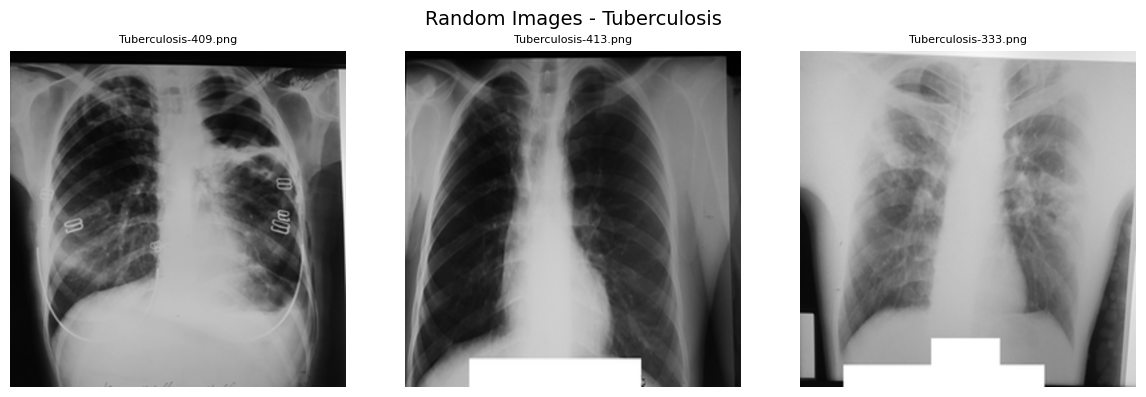

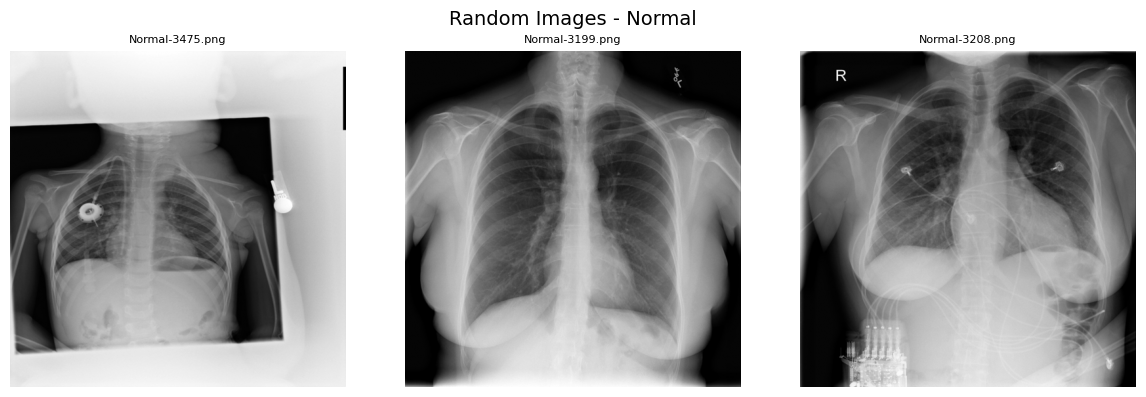

In [9]:
def show_random_images(folder_path, title, num_images=3):
    # List all files in folder (filter to image files if needed)
    all_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Randomly sample files (or just take first 3 if you prefer)
    sample_files = random.sample(all_files, min(num_images, len(all_files)))

    fig, axes = plt.subplots(1, len(sample_files), figsize=(12, 4))
    fig.suptitle(title, fontsize=14)

    for ax, filename in zip(axes, sample_files):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path).convert('L')
        ax.imshow(img, cmap='gray')
        ax.set_title(filename, fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Usage
show_random_images(tb_dir, "Random Images - Tuberculosis")
show_random_images(normal_dir, "Random Images - Normal")


# Determining Best Clip Limit and Grid size

In [10]:
from skimage.measure import shannon_entropy

# Sample grayscale TB image
tb_dir = './chest_xray/TB_Chest_Radiography_Database/Tuberculosis'
sample_img_path = os.path.join(tb_dir, os.listdir(tb_dir)[0])

# Read and convert to grayscale
gray = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)

def evaluate_clahe(image, clip, grid):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(grid, grid))
    enhanced = clahe.apply(image)
    entropy = shannon_entropy(enhanced)
    contrast = enhanced.std()
    return entropy, contrast

results = []

print("🔍 Evaluating different CLAHE settings (entropy & contrast):")

for clip in [1.0, 2.0, 3.0]:
    for grid in [4, 8, 16]:
        ent, con = evaluate_clahe(gray, clip, grid)
        results.append({'Clip Limit': clip, 'Grid Size': grid, 'Entropy': ent, 'Contrast': con})

# Create DataFrame
df_results = pd.DataFrame(results)

# Print the DataFrame in tabular format
print(df_results.to_string(index=False))

🔍 Evaluating different CLAHE settings (entropy & contrast):
 Clip Limit  Grid Size  Entropy  Contrast
        1.0          4 7.600880 83.762379
        1.0          8 7.595753 83.043129
        1.0         16 7.562815 81.401274
        2.0          4 7.724651 82.312459
        2.0          8 7.699416 81.328863
        2.0         16 7.663170 80.150116
        3.0          4 7.776049 80.764809
        3.0          8 7.744146 79.466600
        3.0         16 7.705149 78.289258


# Image Preprocessing

In [11]:
resize_dim = (256, 256)

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, resize_dim, interpolation=cv2.INTER_LINEAR)
    blurred = cv2.GaussianBlur(resized, (5, 5), 0)
    return blurred

#helper functions

def adaptive_canny(image, sigma=0.33):
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return cv2.Canny(image, lower, upper)

def get_lung_mask(enhanced_img):
    blur = cv2.GaussianBlur(enhanced_img, (5, 5), 0)
    _, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    otsu_inv = cv2.bitwise_not(otsu)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    closed = cv2.morphologyEx(otsu_inv, cv2.MORPH_CLOSE, kernel, iterations=2)
    return closed

def suppress_ribs(enhanced_img):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 11))
    opened = cv2.morphologyEx(enhanced_img, cv2.MORPH_OPEN, kernel)
    suppressed = cv2.subtract(enhanced_img, opened)
    return suppressed

#Core processing functions
def enhance_image(blurred_img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    enhanced = clahe.apply(blurred_img)
    return enhanced

def postprocess_image(enhanced_img, apply_rib_suppression=True):
    lung_mask = get_lung_mask(enhanced_img)
    if apply_rib_suppression:
        rib_suppressed = suppress_ribs(enhanced_img)
        masked = cv2.bitwise_and(rib_suppressed, rib_suppressed, mask=lung_mask)
    else:
        masked = cv2.bitwise_and(enhanced_img, enhanced_img, mask=lung_mask)

    edges = adaptive_canny(masked)
    masked_edges = cv2.bitwise_and(edges, edges, mask=lung_mask)
    return masked_edges

def augment_image(image):
    augmented = []

    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Brightness
    brightness = cv2.convertScaleAbs(image, alpha=1, beta=np.random.randint(-50, 50))
    augmented.append(brightness)

    # Contrast
    contrast = cv2.convertScaleAbs(image, alpha=np.random.uniform(1.2, 1.5), beta=0)
    augmented.append(contrast)

    # Rotation
    angle = np.random.randint(-15, 15)
    M = cv2.getRotationMatrix2D((resize_dim[0]//2, resize_dim[1]//2), angle, 1)
    rotated = cv2.warpAffine(image, M, resize_dim)
    augmented.append(rotated)

    # Flip
    flipped = cv2.flip(image, 1)
    augmented.append(flipped)

    return augmented

# ==== Directory processor ====

def process_directory(input_dir, output_dir_with_rib, output_dir_without_rib, augment=False):
    os.makedirs(output_dir_with_rib, exist_ok=True)
    os.makedirs(output_dir_without_rib, exist_ok=True)

    for filename in os.listdir(input_dir):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        path = os.path.join(input_dir, filename)
        preprocessed = preprocess_image(path)

        # Images: original + augmentations
        images_to_process = [preprocessed]
        if augment:
            images_to_process += augment_image(preprocessed)

        for idx, img in enumerate(images_to_process):
            enhanced = enhance_image(img)
            base_name = os.path.splitext(filename)[0]
            suffix = f"_aug{idx}" if idx > 0 else "_orig"

            # With rib suppression
            edges_rib = postprocess_image(enhanced, apply_rib_suppression=True)
            cv2.imwrite(os.path.join(output_dir_with_rib, f"{base_name}{suffix}_enhanced.jpg"), enhanced)
            cv2.imwrite(os.path.join(output_dir_with_rib, f"{base_name}{suffix}_edges.jpg"), edges_rib)

            # Without rib suppression
            edges_no_rib = postprocess_image(enhanced, apply_rib_suppression=False)
            cv2.imwrite(os.path.join(output_dir_without_rib, f"{base_name}{suffix}_enhanced.jpg"), enhanced)
            cv2.imwrite(os.path.join(output_dir_without_rib, f"{base_name}{suffix}_edges.jpg"), edges_no_rib)

# ==== Run ====

tb_dir = './chest_xray/TB_Chest_Radiography_Database/Tuberculosis'
normal_dir = './chest_xray/TB_Chest_Radiography_Database/Normal'

tb_out_dir_with_rib = './chest_xray/Processed_With_Rib/Tuberculosis'
tb_out_dir_without_rib = './chest_xray/Processed_Without_Rib/Tuberculosis'

normal_out_dir_with_rib = './chest_xray/Processed_With_Rib/Normal'
normal_out_dir_without_rib = './chest_xray/Processed_Without_Rib/Normal'

process_directory(tb_dir, tb_out_dir_with_rib, tb_out_dir_without_rib, augment=True)
process_directory(normal_dir, normal_out_dir_with_rib, normal_out_dir_without_rib, augment=False)

print("✅ Processing complete.")


✅ Processing complete.


# Sample Preprocessing - For Visualisation

Note: This is a stand alone code that show the images in pre-process steps of Grayscale, Resizing and Gaussian Blur

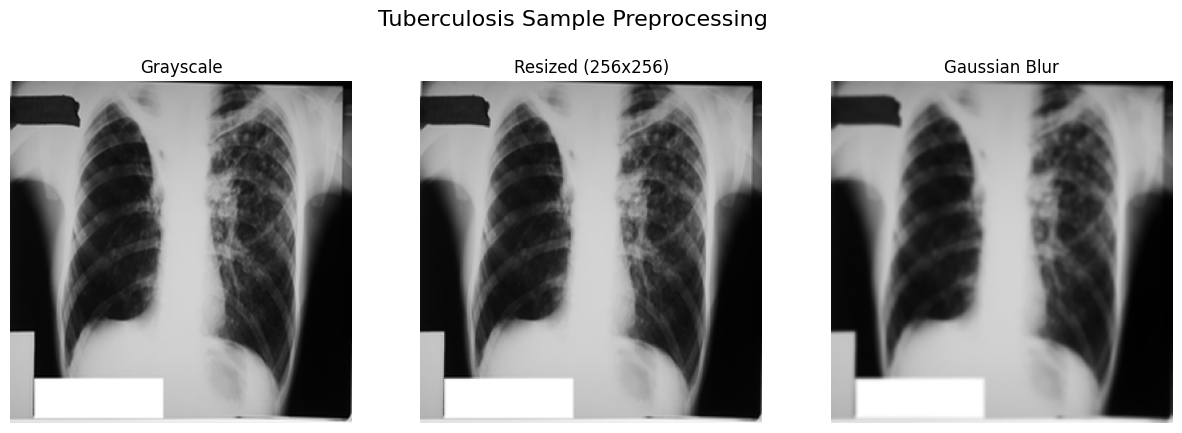

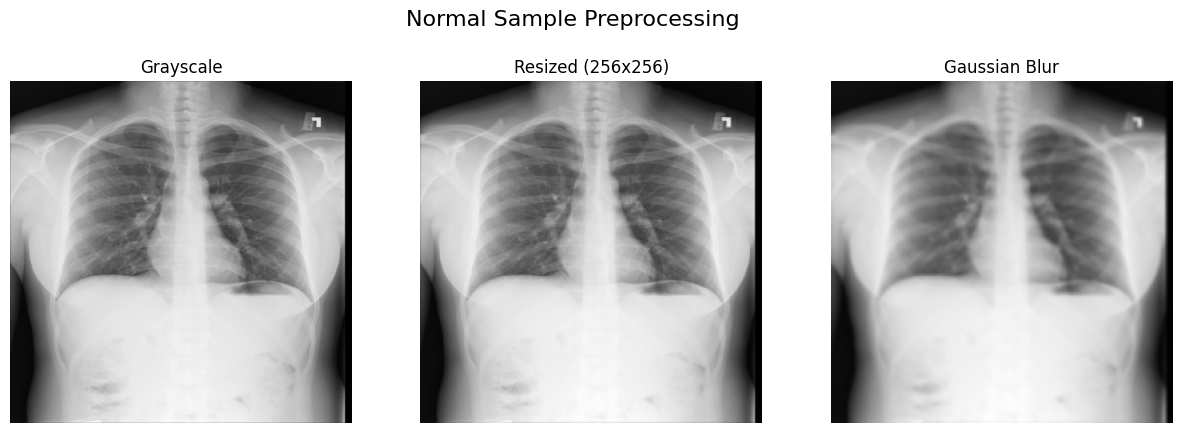

In [12]:
def preprocess_steps(image_path):
    # Read color image
    image = cv2.imread(image_path)

    # Step 1: Grayscale conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 2: Resize
    resized = cv2.resize(gray, (256,256), interpolation=cv2.INTER_LINEAR)

    # Step 3: Gaussian Blur
    blurred = cv2.GaussianBlur(resized, (5, 5), 0)

    return gray, resized, blurred

def show_steps(gray, resized, blurred, title_prefix):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title_prefix, fontsize=16)

    axs[0].imshow(gray, cmap='gray')
    axs[0].set_title('Grayscale')
    axs[0].axis('off')

    axs[1].imshow(resized, cmap='gray')
    axs[1].set_title('Resized (256x256)')
    axs[1].axis('off')

    axs[2].imshow(blurred, cmap='gray')
    axs[2].set_title('Gaussian Blur')
    axs[2].axis('off')

    plt.show()

def get_one_image_path(folder):
    # Get first image file path from folder
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            return os.path.join(folder, fname)
    return None

# Process Tuberculosis sample
tb_image_path = get_one_image_path(tb_dir)
if tb_image_path:
    tb_gray, tb_resized, tb_blurred = preprocess_steps(tb_image_path)
    show_steps(tb_gray, tb_resized, tb_blurred, "Tuberculosis Sample Preprocessing")

# Process Normal sample
normal_image_path = get_one_image_path(normal_dir)
if normal_image_path:
    normal_gray, normal_resized, normal_blurred = preprocess_steps(normal_image_path)
    show_steps(normal_gray, normal_resized, normal_blurred, "Normal Sample Preprocessing")


Show steps of Agumention

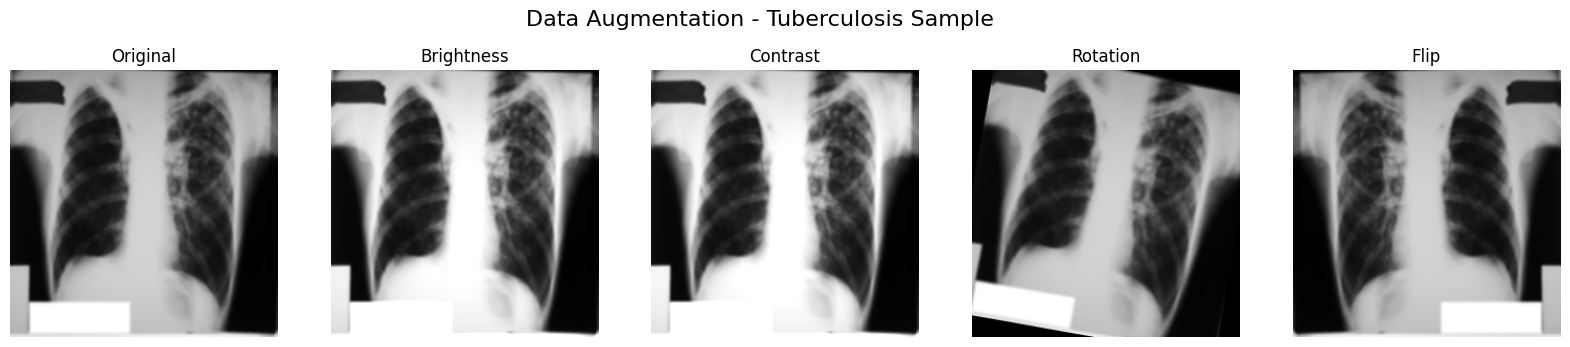

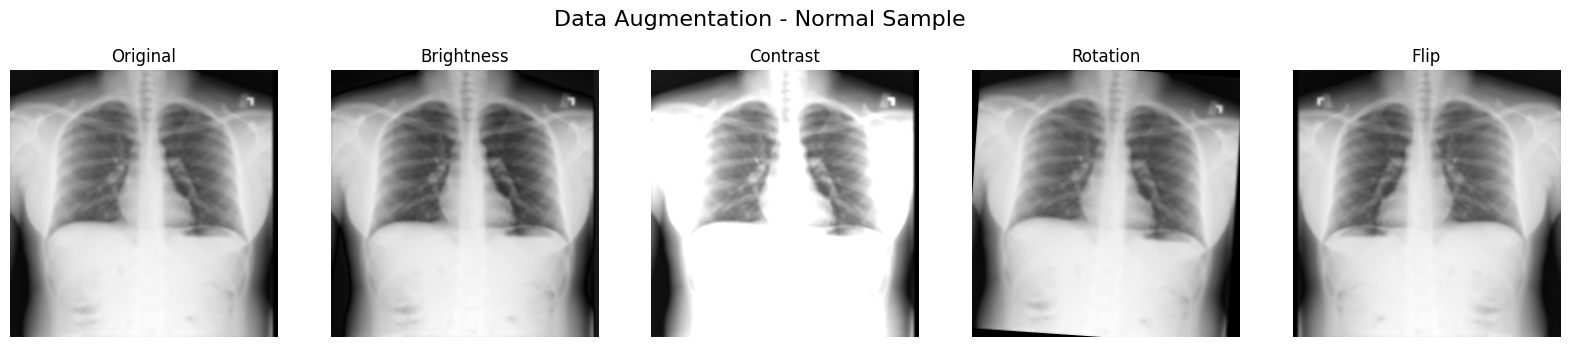

In [13]:
def show_augmentations(original, augmented, title_prefix):
    total_images = 1 + len(augmented)
    fig, axs = plt.subplots(1, total_images, figsize=(4 * total_images, 4))
    fig.suptitle(title_prefix, fontsize=16)

    axs[0].imshow(original, cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    titles = ['Brightness', 'Contrast', 'Rotation', 'Flip']

    for i, aug_img in enumerate(augmented, start=1):
        axs[i].imshow(aug_img, cmap='gray')
        axs[i].set_title(titles[i-1])
        axs[i].axis('off')

    plt.show()

# Tuberculosis image
tb_dir = './chest_xray/TB_Chest_Radiography_Database/Tuberculosis'
image_path = get_one_image_path(tb_dir)

if image_path:
    preprocessed_img = preprocess_image(image_path)
    augmented_imgs = augment_image(preprocessed_img)
    show_augmentations(preprocessed_img, augmented_imgs, "Data Augmentation - Tuberculosis Sample")

# Normal image
tb_dir = './chest_xray/TB_Chest_Radiography_Database/Normal'
image_path = get_one_image_path(normal_dir)

if image_path:
    preprocessed_img = preprocess_image(image_path)
    augmented_imgs = augment_image(preprocessed_img)
    show_augmentations(preprocessed_img, augmented_imgs, "Data Augmentation - Normal Sample")

#Total Dataset after Preprocessing

In [14]:
def count_images_in_dir(directory):
    return len([f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

print(f"TB images processed with rib suppression: {count_images_in_dir(tb_out_dir_with_rib)}")
print(f"TB images processed without rib suppression: {count_images_in_dir(tb_out_dir_without_rib)}")
print(f"Normal images processed with rib suppression: {count_images_in_dir(normal_out_dir_with_rib)}")
print(f"Normal images processed without rib suppression: {count_images_in_dir(normal_out_dir_without_rib)}")


TB images processed with rib suppression: 7000
TB images processed without rib suppression: 7000
Normal images processed with rib suppression: 7000
Normal images processed without rib suppression: 7000


# New Directory List

In [15]:
# Set your processed directory (TB or Normal)
processed_tb_dir = './chest_xray/Processed_With_Rib/Tuberculosis'
processed_normal_dir = './chest_xray/Processed_Without_Rib/Normal'

import os

print("Directory exists:", os.path.exists(processed_tb_dir))
print("Number of files:", len(os.listdir(processed_tb_dir)))

#list a few name from directory
for filename in os.listdir(processed_tb_dir)[:5]:
    print(filename)
print()
print("Directory exists:", os.path.exists(processed_normal_dir))
print("Number of files:", len(os.listdir(processed_normal_dir)))

for filename in os.listdir(processed_normal_dir)[:5]:
    print(filename)

Directory exists: True
Number of files: 7000
Tuberculosis-285_aug1_edges.jpg
Tuberculosis-450_aug2_enhanced.jpg
Tuberculosis-471_orig_edges.jpg
Tuberculosis-388_aug1_edges.jpg
Tuberculosis-328_aug3_edges.jpg

Directory exists: True
Number of files: 7000
Normal-1189_orig_edges.jpg
Normal-2034_orig_edges.jpg
Normal-3482_orig_edges.jpg
Normal-2298_orig_edges.jpg
Normal-2760_orig_edges.jpg


#Sample Core Processing Steps

This includes images (data) after it has been processed with CLAHE (Enhanced), Canny Edge detected image withand without ribs.

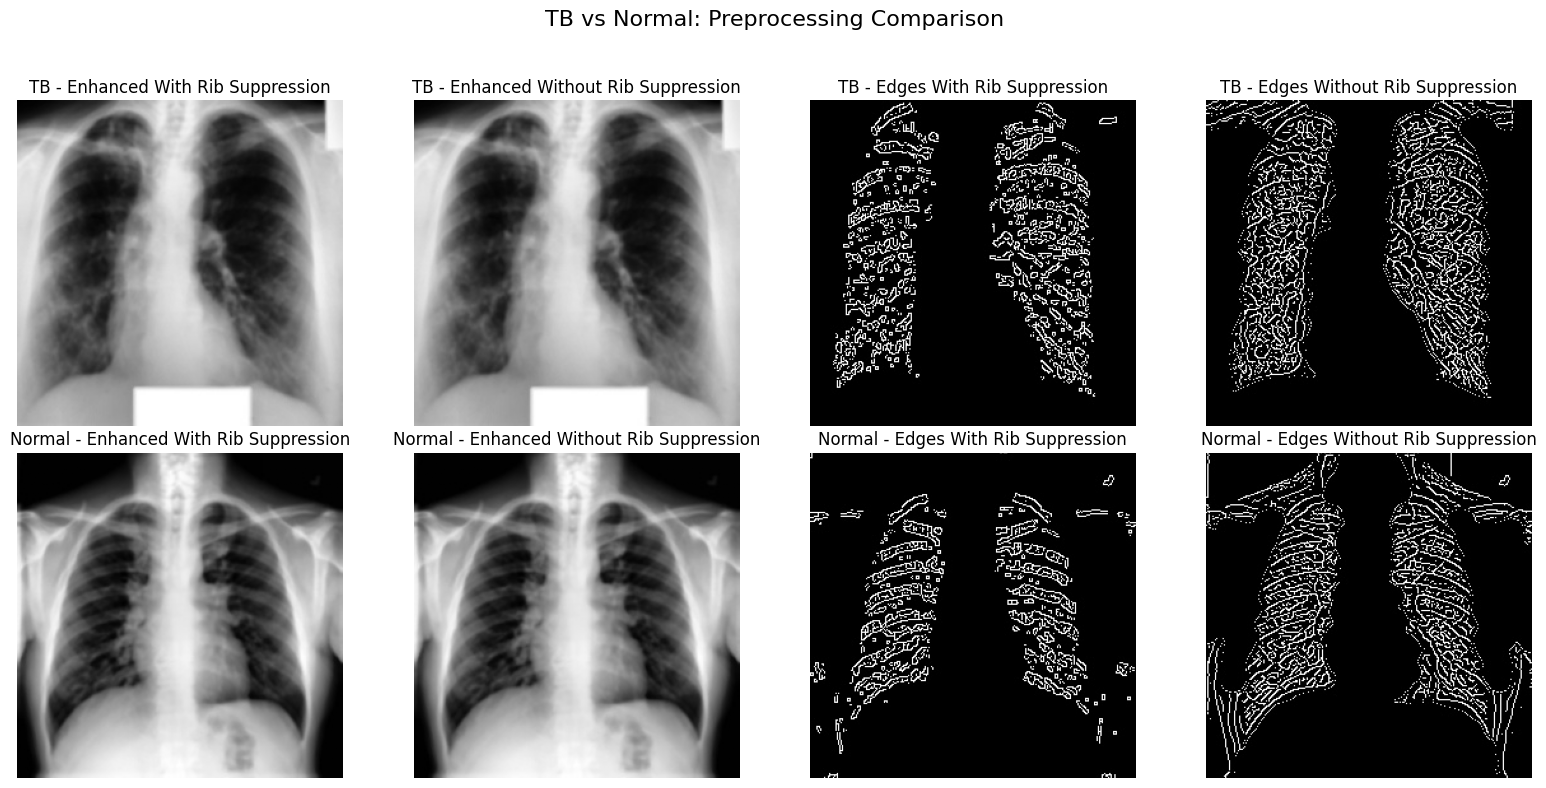

In [17]:
# Sample images
tb_sample_name = 'Tuberculosis-1_orig'
normal_sample_name = 'Normal-9_orig'

# Directories where processed images are stored
dir_with_rib = './chest_xray/Processed_With_Rib'
dir_without_rib = './chest_xray/Processed_Without_Rib'

def load_processed_images(base_name, class_name):
    """Load images for one sample (blurred, enhanced, edges with & without rib)"""
    paths = {
        "Enhanced With Rib Suppression": os.path.join(dir_with_rib, class_name, f"{base_name}_enhanced.jpg"),
        "Enhanced Without Rib Suppression": os.path.join(dir_without_rib, class_name, f"{base_name}_enhanced.jpg"),
        "Edges With Rib Suppression": os.path.join(dir_with_rib, class_name, f"{base_name}_edges.jpg"),
        "Edges Without Rib Suppression": os.path.join(dir_without_rib, class_name, f"{base_name}_edges.jpg"),
    }

    images = {}
    for key, path in paths.items():
        if os.path.exists(path):
            images[key] = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        else:
            print(f"Missing: {path}")
            images[key] = None
    return images

tb_images = load_processed_images(tb_sample_name, 'Tuberculosis')
normal_images = load_processed_images(normal_sample_name, 'Normal')

# Plotting
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("TB vs Normal: Preprocessing Comparison", fontsize=16)

steps = ["Enhanced With Rib Suppression", "Enhanced Without Rib Suppression", "Edges With Rib Suppression", "Edges Without Rib Suppression"]

for col, step in enumerate(steps):
    # TB row
    ax_tb = axes[0, col]
    if tb_images[step] is not None:
        ax_tb.imshow(tb_images[step], cmap='gray')
    ax_tb.set_title(f"TB - {step}")
    ax_tb.axis('off')

    # Normal row
    ax_n = axes[1, col]
    if normal_images[step] is not None:
        ax_n.imshow(normal_images[step], cmap='gray')
    ax_n.set_title(f"Normal - {step}")
    ax_n.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import os
import numpy as np
import cv2
from skimage.feature import hog
from tqdm import tqdm
import joblib

#Directory paths
directories = {
    'tb_with_rib': './chest_xray/Processed_With_Rib/Tuberculosis',
    'tb_without_rib': './chest_xray/Processed_Without_Rib/Tuberculosis',
    'normal_with_rib': './chest_xray/Processed_With_Rib/Normal',
    'normal_without_rib': './chest_xray/Processed_Without_Rib/Normal'
}

#HOG parameters
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'visualize': False,
    'feature_vector': True
}

#Output containers
features_with_rib = []
labels_with_rib = []
features_without_rib = []
labels_without_rib = []

#Label mapping
label_map = {
    'tb_with_rib': 1,
    'tb_without_rib': 1,
    'normal_with_rib': 0,
    'normal_without_rib': 0
}

#HOG feature extraction
for label_key, dir_path in directories.items():
    print(f"Processing: {label_key}")
    for file in tqdm(os.listdir(dir_path)):
        if '_edges' not in file or not file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        image_path = os.path.join(dir_path, file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        features = hog(image, **hog_params)
        label = label_map[label_key]

        if 'with_rib' in label_key:
            features_with_rib.append(features)
            labels_with_rib.append(label)
        else:
            features_without_rib.append(features)
            labels_without_rib.append(label)

#Convert to NumPy arrays
features_with_rib = np.array(features_with_rib)
labels_with_rib = np.array(labels_with_rib)
features_without_rib = np.array(features_without_rib)
labels_without_rib = np.array(labels_without_rib)

#Save to disk
np.save('hog_features_with_rib.npy', features_with_rib)
np.save('hog_labels_with_rib.npy', labels_with_rib)
np.save('hog_features_without_rib.npy', features_without_rib)
np.save('hog_labels_without_rib.npy', labels_without_rib)

joblib.dump((features_with_rib, labels_with_rib), 'hog_dataset_with_rib.pkl')
joblib.dump((features_without_rib, labels_without_rib), 'hog_dataset_without_rib.pkl')

print("HOG feature extraction completed.")
print(f"With rib suppression: {len(features_with_rib)} samples | Feature vector size: {features_with_rib.shape[1]}")
print(f"Without rib suppression: {len(features_without_rib)} samples | Feature vector size: {features_without_rib.shape[1]}")

🔍 Processing: tb_with_rib


100%|██████████| 10500/10500 [02:04<00:00, 84.57it/s]


🔍 Processing: tb_without_rib


100%|██████████| 10500/10500 [01:53<00:00, 92.85it/s] 


🔍 Processing: normal_with_rib


100%|██████████| 10500/10500 [01:56<00:00, 90.30it/s]


🔍 Processing: normal_without_rib


100%|██████████| 10500/10500 [01:55<00:00, 90.62it/s]



✅ HOG feature extraction completed.
With rib suppression: 7000 samples | Feature vector size: 34596
Without rib suppression: 7000 samples | Feature vector size: 34596
